In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
housedata=fetch_california_housing()
train_x,test_x,train_y,test_y=train_test_split(housedata.data,housedata.target,test_size=0.3,random_state=42)
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)
train_x.shape,train_y.shape,test_x.shape,test_y.shape,min(test_y),max(train_y)

((14448, 8), (14448,), (6192, 8), (6192,), 0.14999, 5.00001)

In [2]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]
             
#preparing teacher's datasets
n_teachers=10
teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=32,shuffle=True)
                           for i in range(n_teachers))
# print(teacher_x)


print ('preparing students dataset')
student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)
# model_valid_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]))
student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]))
samples= student_x[i].shape[0]
print(samples)


0 (1445, 8) (1445,)
1 (1445, 8) (1445,)
2 (1445, 8) (1445,)
3 (1445, 8) (1445,)
4 (1445, 8) (1445,)
5 (1445, 8) (1445,)
6 (1445, 8) (1445,)
7 (1445, 8) (1445,)
8 (1445, 8) (1445,)
9 (1443, 8) (1443,)
preparing students dataset
0 (3096, 8) (3096,)
1 (3096, 8) (3096,)
3096


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
from pyro.distributions import Normal
from pyro.distributions import Categorical
from pyro.optim import Adam
from pyro.infer import SVI
from pyro.infer import Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)).to(device))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)).to(device))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(8,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x)).to(device)
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_posts = torch.zeros(samples).to(device)
        log_likes = torch.zeros(samples).to(device)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1).to(device) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss

BNN = MLP_BBB(40, prior_var=1).to(device)
print(BNN)


MLP_BBB(
  (hidden): Linear_BBB()
  (out): Linear_BBB()
)


In [4]:
 
#training configs
num_epochs=1200
batch_size =32
lr =1e-3
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = BNN
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]

#creating teachers folders
import os
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/teacher{i}')

In [5]:
#training teacher models
loss_func=nn.MSELoss()
train_loss_all=[]
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    for epoch in range(num_epochs):
        train_loss = 0
        train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num](b_x.to(device))
            loss=loss_func(output,b_y)
            loss.backward()
            teacher_optimizers[tea_num].step()
            
            teacher_optimizers[tea_num].zero_grad()
            loss_houyan = teachers_model[tea_num].sample_elbo(b_x.to(device),b_y.to(device),1)
            loss_houyan.backward()
            teacher_optimizers[tea_num].step()

            train_loss+=loss.item() * b_x.size(0)
            train_num += b_x.size(0)
            loss_tea = train_loss/train_num
            
            if loss_tea< minloss:
                minloss = loss_tea
                if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/teacher{tea_num}/best.pth'):
                    os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/teacher{tea_num}/best.pth')
        if epoch%10== 0:
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss_tea}', f' loss_houyan:{loss_houyan}')
        train_loss_all.append(loss) 
    print(f'finished training number {tea_num} techer!')          

start training number 0 techer!


/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:0 epoch: 1/1200 loss_tea:10.697375101861656  loss_houyan:11414.044921875
Number:0 epoch: 11/1200 loss_tea:4.508857118217178  loss_houyan:2944.045166015625
Number:0 epoch: 21/1200 loss_tea:6.486080382522002  loss_houyan:1905.168212890625
Number:0 epoch: 31/1200 loss_tea:6.893526911653037  loss_houyan:385.7079772949219
Number:0 epoch: 41/1200 loss_tea:4.539849673381727  loss_houyan:604.1119995117188
Number:0 epoch: 51/1200 loss_tea:3.622980091233567  loss_houyan:922.5023803710938
Number:0 epoch: 61/1200 loss_tea:3.7508307598041415  loss_houyan:119.32247924804688
Number:0 epoch: 71/1200 loss_tea:3.2685846960255844  loss_houyan:369.863525390625
Number:0 epoch: 81/1200 loss_tea:3.168438045871299  loss_houyan:272.14971923828125
Number:0 epoch: 91/1200 loss_tea:2.932537368589619  loss_houyan:2759.9736328125
Number:0 epoch: 101/1200 loss_tea:2.8283105368432704  loss_houyan:485.7212829589844
Number:0 epoch: 111/1200 loss_tea:2.6928471519047825  loss_houyan:838.5130004882812
Number:0 epoc

/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:9 epoch: 1/1200 loss_tea:2.2373183965682983  loss_houyan:282.894775390625
Number:9 epoch: 11/1200 loss_tea:2.2233966269678156  loss_houyan:198.7427215576172
Number:9 epoch: 21/1200 loss_tea:2.2490472755577526  loss_houyan:217.35330200195312
Number:9 epoch: 31/1200 loss_tea:2.247324367488166  loss_houyan:254.30862426757812
Number:9 epoch: 41/1200 loss_tea:2.2325457204817405  loss_houyan:191.72555541992188
Number:9 epoch: 51/1200 loss_tea:2.2534933800674195  loss_houyan:274.36578369140625
Number:9 epoch: 61/1200 loss_tea:2.2519494051414486  loss_houyan:357.6236572265625
Number:9 epoch: 71/1200 loss_tea:2.2606455225623985  loss_houyan:218.90286254882812
Number:9 epoch: 81/1200 loss_tea:2.2754194251547566  loss_houyan:207.6839599609375
Number:9 epoch: 91/1200 loss_tea:2.280402369719781  loss_houyan:200.67031860351562
Number:9 epoch: 101/1200 loss_tea:2.244479770998697  loss_houyan:220.83349609375
Number:9 epoch: 111/1200 loss_tea:2.238097152029237  loss_houyan:389.77642822265625
Num

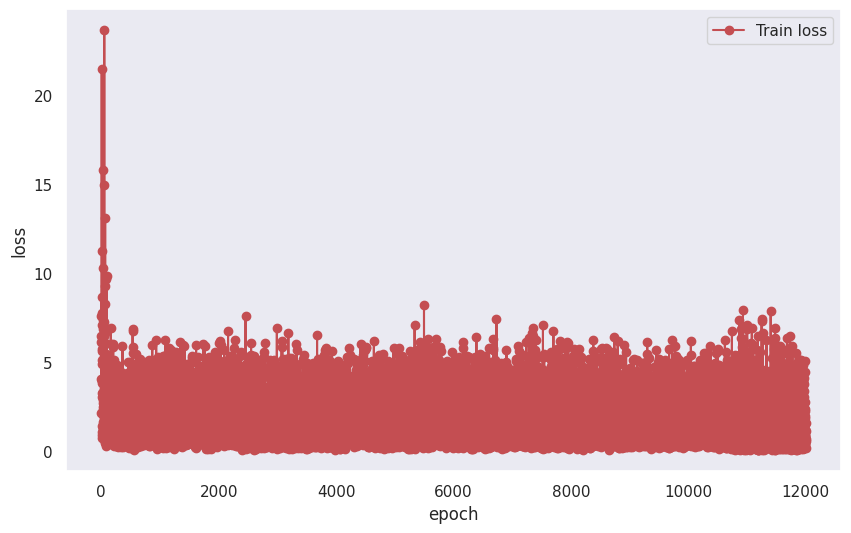

In [16]:
    
plt.figure(figsize=(10,6))

train_loss_all  = torch.tensor(train_loss_all,device='cpu')
plt.plot(train_loss_all ,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()   
            

In [17]:
print(samples)
y_samp = np.zeros((samples,1))
for s in range(samples):
    for b_x,b_y  in student_train_loader:
        y = net (b_x[s]).cpu().detach().numpy()
        y_samp[s] = y.reshape(-1)

lower = np.percentile(y_samp, 2.5, axis = 0)
upper = np.percentile(y_samp, 97.5, axis = 0)
print(lower,upper)
count = 0 
for i in range(samples):
    for b_x,b_y in student_train_loader:
        if lower<=b_y[i].item()<=upper:
            count+=1
per = 1-count/samples
print (count,per,samples-count)
#α
upper=torch.tensor(upper).to(device)
lower= torch.tensor(lower).to(device)
print(lower)
print(upper)



3096
[0.51445022] [5.11542988]
3059 0.011950904392764805 37
tensor([0.5145], device='cuda:1', dtype=torch.float64)
tensor([5.1154], device='cuda:1', dtype=torch.float64)


In [18]:
#certainty aware
import random
import numpy as np
mu = 0
# sigma = 1
# sigma =2
# sigma=3
sigma=3.028

#teahcer labeling
teacher_best_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]


pos= torch.zeros(samples,n_teachers).to(device)
#用0标记无效值 数据集已ln处理 无ln0
# 记录每个老师 针对拿到的数据 预测出来的如果符合置信区间内，那就记录在内，如果不在 则剔除该值
ccc = 0
sss=0#记录有效数量 ;  β%=ccc/(sss+ccc)
for tea in range(n_teachers):
    for x,y in student_train_loader:
            teacher_best_models[tea].eval().to(device)
            pred=teacher_best_models[tea].forward(x)

            pred+=random.gauss(mu,sigma)
            for i in range(samples):
                if lower.item()<= pred[i].item() <= upper.item():
                    #如果在内 记录
                    pos[i][tea]+=pred[i].item()
                    sss+=1
                else:
                    ccc+=1
print(pos,pos.shape,ccc/(sss+ccc))            

#针对pos中有效值（非0数）进行处理  →  每个老师打出标签做均值求和 
res= torch.zeros(samples,1).to(device)
count_data=0
count_sum=0
for i in range(samples):
    for j in range(n_teachers):
        if pos[i][j]!=0:
            count_data+=1
            count_sum+=pos[i][j]

    if count_data==0:#表明n个老师打出的值均无效//避免除以0//零值
        print('False')
    cur=count_sum/count_data #data1 +....datan//K
    res[i]+=cur#有效的均值标签
print(res)

tensor([[0.0000, 0.0000, 2.8388,  ..., 0.0000, 2.7433, 0.0000],
        [0.0000, 0.0000, 1.5391,  ..., 3.1841, 1.9641, 0.0000],
        [0.0000, 0.0000, 1.0721,  ..., 3.2811, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 5.0702,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 3.7439,  ..., 4.0381, 0.0000, 0.0000],
        [0.0000, 0.0000, 4.2896,  ..., 4.1645, 0.5253, 0.0000]],
       device='cuda:1') torch.Size([3096, 10]) 0.5458979328165374
tensor([[2.1128],
        [2.3143],
        [2.3275],
        ...,
        [2.6863],
        [2.6864],
        [2.6862]], device='cuda:1')


In [19]:
#student_label
student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(res,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)

/tmp/ipykernel_2769242/2143468446.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(res,device=device,dtype=torch.float))


In [20]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/stu')

In [21]:
# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=8, out_features=256, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=256, out_features=64, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=64, out_features=16, bias=True),
                                  nn.Dropout(0.5),
                                  nn.ReLU()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=16, out_features=1, bias=True),
                                        nn.ReLU())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]


mlpreg=MLP().to(device)
print(mlpreg)
#initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4) 

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
  )
  (predict): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [22]:
#train student model
loss_func=nn.MSELoss()
print('start training')
train_loss_all_stu=[]
minloss=float('inf')
for epoch in  range(500):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x.to(device))
        loss=loss_func(output,b_y)
        loss.backward()
        student_optimizer.step()
        train_loss+=loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        loss_stu = train_loss/train_num
        if loss_stu < minloss:
            minloss = loss_stu
            if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/stu/best.pth'):
                os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/stu/best.pth')
            torch.save(student_model, f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/stu/best.pth')
    # if epoch%1 == 0:
    print(f'student train: Epo:{epoch}  Loss_stu:{loss_stu}')
    train_loss_all_stu.append(loss_stu)
        


start training


/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ysy/anaconda3/envs/bnn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


student train: Epo:0  Loss_stu:6.474905026359459
student train: Epo:1  Loss_stu:4.859234451323516
student train: Epo:2  Loss_stu:3.5882337758707448
student train: Epo:3  Loss_stu:3.247581213943718
student train: Epo:4  Loss_stu:3.711885659885653
student train: Epo:5  Loss_stu:3.7548939873697837
student train: Epo:6  Loss_stu:2.475243135324128
student train: Epo:7  Loss_stu:2.906385845300147
student train: Epo:8  Loss_stu:2.4886246574633497
student train: Epo:9  Loss_stu:2.424465664905479
student train: Epo:10  Loss_stu:2.29482523569457
student train: Epo:11  Loss_stu:2.021989417014504
student train: Epo:12  Loss_stu:2.1961490060623916
student train: Epo:13  Loss_stu:2.637243472328482
student train: Epo:14  Loss_stu:1.9850547563198
student train: Epo:15  Loss_stu:1.9833903827100454
student train: Epo:16  Loss_stu:1.8072168753128643
student train: Epo:17  Loss_stu:1.6676025313616416
student train: Epo:18  Loss_stu:1.9223097852342197
student train: Epo:19  Loss_stu:1.5584235915225915
stud

In [23]:
# 保存
import numpy as np
b=np.array(train_loss_all_stu)

np.save('/home/ysy/ysy/Fed-ReKD/california_our_e8_loss.npy',b)   # 保存为.npy格式


In [24]:
#eval  student model
student_best_model =torch.load('/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_8_gauss/stu/best.pth')

for x,y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(x)
    loss_test=loss_func(pred,y) 
print(f'student test Loss:{loss_test}')

student test Loss:1.718182921409607
